In [1]:
import seaborn as sns
import os
import sys
import numpy as np
import random

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiments.result_buckets import human_results
from experiments.bucket_analysis import BucketDatasetResult

%load_ext autoreload
%autoreload 2

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 15986.83it/s]


### Main Consistency Section (Section 5)

In [2]:
## section 5 table 3

for dataset in ['snli', 'atomic', 'social', 'anli']:
    bucket_preds = human_results['roberta'][f'{dataset}-human']
    test_preds = human_results['roberta'][f'{dataset}-test']

    print(dataset)
    print('C:', bucket_preds.mean_unweighted_consistency)
    print('C_w:', bucket_preds.calculate_weighted_consistency(test_preds))
    print('POVE:', bucket_preds.law_of_total_variance_breakdown()['prop_explained'])
    print('POVE_w:', bucket_preds.calculate_weighted_proportion_explained(test_preds))
    print()

snli
C: 0.7052253968253969
C_w: 0.9064806546026608
POVE: 0.4938082810751717
POVE_w: 0.33477624667106926

atomic
C: 0.7478507936507937
C_w: 0.8616549681381606
POVE: 0.5186940972384994
POVE_w: 0.4083021609486061

social
C: 0.6592190476190476
C_w: 0.9087363234357935
POVE: 0.47714706628859094
POVE_w: 0.3302885539058762

anli
C: 0.6805238095238096
C_w: 0.8744013294599748
POVE: 0.38334927850754574
POVE_w: 0.2656007255507767



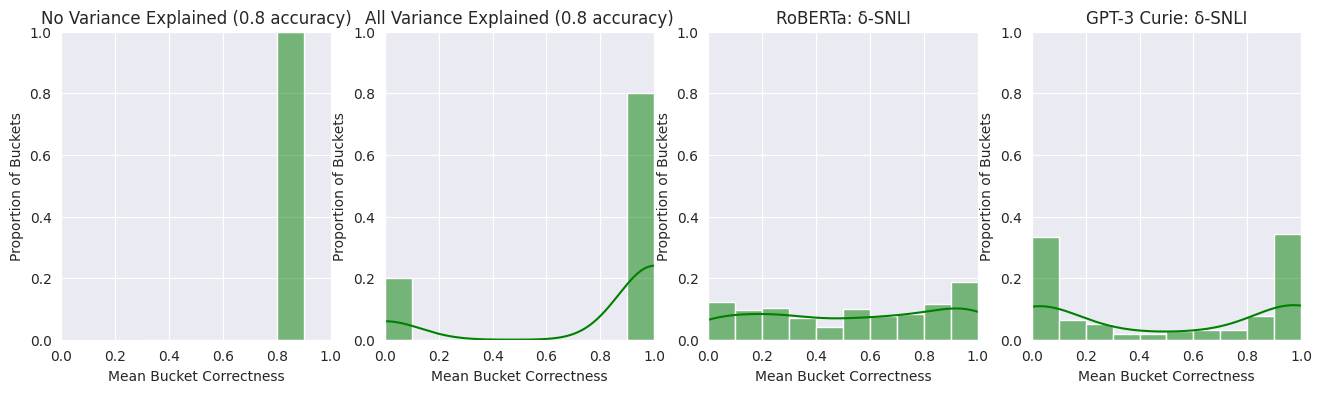

In [4]:
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

plot_data = {
    'No Variance Explained (0.8 accuracy)': {
        'data': [0.8] * len(human_results['roberta']['snli-human'].buckets),
        'color': "green"
    },
    'All Variance Explained (0.8 accuracy)': {
        'data': [1] * int(0.8 * len(human_results['roberta']['snli-human'].buckets)) + [0] * int(0.2 * len(human_results['roberta']['snli-human'].buckets)),
        'color': "green"
    },
    'RoBERTa: δ-SNLI': {
        'data': [b.bucket_correctness_mean for b in human_results['roberta']['snli-human'].buckets],
        'color': "green"
    },
    'GPT-3 Curie: δ-SNLI': {
        'data': [b.bucket_correctness_mean for b in human_results['gpt3_curie']['snli-human'].buckets],
        'color': "green"
    },
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (title, pdata) in enumerate(plot_data.items()):
    sns.histplot(pdata['data'], kde=True, stat='proportion', bins=10, ax=axes[i], color=pdata['color'])
    axes[i].set_xlabel("Mean Bucket Correctness")
    axes[i].set_ylabel("Proportion of Buckets")
    axes[i].set_title(title)
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)

plt.savefig('pove.pdf')
plt.show()


In [1]:
from simple_colors import *
import matplotlib.pyplot as plt
x = []
y = []
names = []

for model, results in human_results.items():
    analysis = results['snli-human']
    test_results = results['snli-test']
    
    print(green(model))
    variance_law = analysis.law_of_total_variance_breakdown()
    test_set_accuracy = test_results.accuracy
    # print('Total variance:', variance_law['total_var_y'])
    # print('Test set accuracy:', test_set_accuracy)
    # print('Paraphrase acc:', analysis.paraphrase_accuracy())
    # print('Variance of bernoulli with acc:', (analysis.paraphrase_accuracy() * (1-analysis.paraphrase_accuracy())))

    print("#### Agreement Consistency ####")
    print('Consistency:', analysis.mean_unweighted_consistency)
    print('Corrected consistency:', analysis.calculate_weighted_consistency(test_results))

    print("\n#### POVE ####")
    print('POVE:', variance_law['prop_explained'])
    print('POVE Corrected:', analysis.calculate_weighted_proportion_explained(test_results))
    
    
    print()
    x.append(test_set_accuracy)
    y.append(analysis.calculate_weighted_proportion_explained(test_results))
    names.append(model)

sns.scatterplot(x=x, y=y)
for i in range(len(names)):
    plt.text(x[i]-0.01, y[i]-0.03, names[i], fontsize=10, ha='center', va='center', color='blue')

ax = plt.gca()
ax.set_xlabel("Test Set Accuracy")
ax.set_ylabel("Corrected Proportion of Variance Explained")

NameError: name 'human_results' is not defined

In [ ]:
import plotly.express as px

# This plot shows that the there is positive correlation between how extreme the confidence is and discrete consistency.

model = human_results['roberta']['snli-human']

x = [b.original_example_prediction.confidence_deviation for b in model.buckets]
y = [b.bucket_discrete_agreement for b in model.buckets]

fig = px.scatter(x=x, y=y, labels={'x': 'deviation', 'y': 'discrete_agreement'}, trendline="ols")

fig.show()